# Pure Premium Modelling with Tweedie GLM

## Loading data
Let us load the datasets and take a look at them

In [1]:
import pandas as pd
import numpy as np
freMTPLfreq = pd.read_csv('./data/freMTPLfreq.csv', sep=';')
freMTPLsev = pd.read_csv('./data/freMTPLsev.csv', sep=';')
freMTPLfreq.head()

,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
0,1,0,"0,09",g,0,46,Japanese (except Nissan) or Korean,Diesel,R72,76
1,2,0,"0,84",g,0,46,Japanese (except Nissan) or Korean,Diesel,R72,76
2,3,0,"0,52",f,2,38,Japanese (except Nissan) or Korean,Regular,R31,3003
3,4,0,"0,45",f,2,38,Japanese (except Nissan) or Korean,Regular,R31,3003
4,5,0,"0,15",g,0,41,Japanese (except Nissan) or Korean,Diesel,R52,60


In [2]:
freMTPLsev.head()

,PolicyID,ClaimAmount
0,63987,1172
1,310037,1905
2,314463,1150
3,318713,1220
4,309380,55077


## Preprocessing data
Data is split into two separate csv files: `freMTPLfreq.csv` with general policy features, and `freMTPLsev.csv` with individual claims and associated losses.

We need to:
* Calculate accumulated losses for each policy
* Join the datasets into one
* Preprocess general features

In [3]:
freMTPLfreq['Exposure'] = freMTPLfreq.Exposure.apply(lambda e: float(e.replace(',', '.')))
freMTPLfreq['Intercept'] = 1
freMTPLfreq['CarAge'] = pd.cut(freMTPLfreq.CarAge, bins=(0, 1, 4, 15, float('Inf')), right=False)
freMTPLfreq['DriverAge'] = pd.cut(freMTPLfreq.DriverAge, bins=(18, 22, 26, 42, 74, float('Inf')), right=False)
freMTPLfreq['Density'] = pd.cut(freMTPLfreq.Density, bins=(0, 40, 200, 500, 4500, float('Inf')), right=False)

freMTPLsev = freMTPLsev.groupby(by='PolicyID').sum()
freMTPLsev.shape

freMTPL = freMTPLfreq.join(freMTPLsev, on='PolicyID', how='left')
freMTPL.ClaimAmount.fillna(0, inplace=True)

X = pd.get_dummies(freMTPL.drop(['PolicyID', 'Exposure', 'ClaimNb', 'ClaimAmount'], axis=1), drop_first=True)
y = freMTPL.ClaimAmount
exposure = freMTPL.Exposure

## Training the model
We are ready to train our GLM model. `X` variable contains traning columns, `y` contrains target variable.

In [4]:
import statsmodels.api as sm
model = sm.GLM(exog=X, endog=y, exposure=exposure, family=sm.families.Tweedie(var_power=1.5))
report = model.fit()
report.summary()

/Users/alexander/.pyenv/versions/3.6.3/envs/intro-to-ml-3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            ClaimAmount   No. Observations:               413169
Model:                            GLM   Df Residuals:                   413130
Model Family:                 Tweedie   Df Model:                           38
Link Function:                    log   Scale:                    17173.022484
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 30 Oct 2017   Deviance:                   2.5936e+07
Time:                        17:56:01   Pearson chi2:                 7.09e+09
No. Iterations:                    19                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    7.1319      0.664     10.741      0.000       5.831       8.433
Power_e                                      0.0977      0.240      0.407      0.684      -0.372       0.568
Power_f                                      0.3698      0.230      1.605      0.108      -0.082       0.821
Power_g                                      0.1069      0.231      0.462      0.644      -0.347       0.560
Power_h                                      0.1483      0.338      0.439      0.660      -0.513       0.810
Power_i                                      0.5535      0.354      1.565      0.118      -0.140       1.247
Power_j                                      0.2194      0.385      0.570      0.569      -0.535       0.974
Power_k                                      0.3355      0.492      0.682      0.495      -0.629       1.300
Power_l                                      0.1434      0.723      0.198      0.843      -1.273       1.560
Power_m                                      0.2859      1.046      0.273      0.785      -1.764       2.336
Power_n                                      0.4410      1.191      0.370      0.711      -1.893       2.775
Power_o                                      0.0412      1.282      0.032      0.974      -2.471       2.553
CarAge_[1.0, 4.0)                            0.0552      0.340      0.163      0.871      -0.611       0.721
CarAge_[4.0, 15.0)                           0.0277      0.336      0.082      0.934      -0.631       0.686
CarAge_[15.0, inf)                          -0.2780      0.386     -0.720      0.471      -1.034       0.478
DriverAge_[22.0, 26.0)                      -1.7536      0.407     -4.309      0.000      -2.551      -0.956
DriverAge_[26.0, 42.0)                      -2.5567      0.316     -8.089      0.000      -3.176      -1.937
DriverAge_[42.0, 74.0)                      -2.6506      0.310     -8.548      0.000      -3.258      -2.043
DriverAge_[74.0, inf)                       -2.6198      0.433     -6.049      0.000      -3.469      -1.771
Brand_Japanese (except Nissan) or Korean     0.1277      0.416      0.307      0.759      -0.687       0.943
Brand_Mercedes, Chrysler or BMW              0.4144      0.486      0.853      0.393      -0.537       1.366
Brand_Opel, General Motors or Ford           0.2714      0.420      0.646      0.518      -0.552       1.095
Brand_Renault, Nissan or Citroen             0.3093      0.368      0.839      0.401      -0.413       1.031
Brand_Volkswagen, Audi, Skoda or Seat        0.2776      0.427      0.650      0.515      -0.559       1.114
Brand_other                                  0.2691      0.563      0.478      0.632      -0.834       1.372
Gas_Regular                                 -0.0631      0.148     -0.427      0.670      -0.353       0.227
R

## Visualising results
Let's visualize fitted weights for each feature

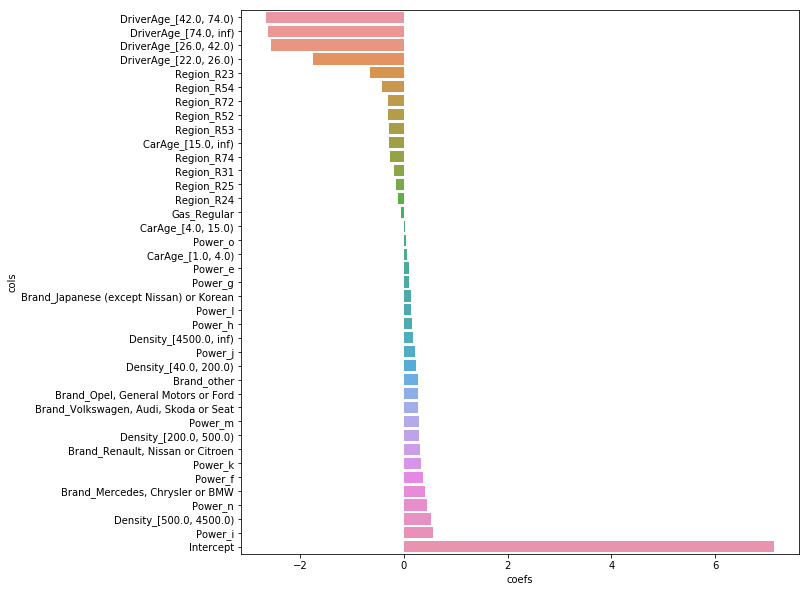

In [5]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
cols = X.columns
coefs = report.fit_history['params'][-1]
rep = pd.DataFrame(data={ 'cols': cols, 'coefs': coefs }).sort_values(by='coefs')
sns.barplot(x='coefs', y='cols', data=rep, ax=plt.subplots(figsize=(10, 10))[1])

## Making predictions

In [6]:
X.head(1)

,Intercept,Power_e,Power_f,Power_g,Power_h,Power_i,Power_j,Power_k,Power_l,Power_m,...,Region_R31,Region_R52,Region_R53,Region_R54,Region_R72,Region_R74,"Density_[40.0, 200.0)","Density_[200.0, 500.0)","Density_[500.0, 4500.0)","Density_[4500.0, inf)"
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [7]:
model.predict(exog=X.values[0], exposure=exposure.values[0], params=report.fit_history['params'][-1])

9.3581738487340704